# Casus

## Inleiding

In dit document maak ik een data sciene pipeline. Ik ga data analyseren en een model trainen om antwoord te geven op de volgende onderzoeksvraag:

_Hoe groot is de kans dat een werknemer geestelijke gezondheidszorg nodig heeft?_

Om deze onderzoeksvraag te beantwoorden ga ik de 'Data Understanding', 'Data Preparation', 'Modeling' en 'Evaluation' stappen van het CRISP-DM model doorlopen.

## Data Understanding

Ik ga de dataset eerst verkennen om een idee te krijgen van de features en wat deze betekenen.

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

In [25]:
# data inladen
data = pd.read_csv("mental_health_dataset.csv")
data.head()

,age,gender,employment_status,work_environment,mental_health_history,seeks_treatment,stress_level,sleep_hours,physical_activity_days,depression_score,anxiety_score,social_support_score,productivity_score,mental_health_risk
0,56,Male,Employed,On-site,Yes,Yes,6,6.2,3,28,17,54,59.7,High
1,46,Female,Student,On-site,No,Yes,10,9.0,4,30,11,85,54.9,High
2,32,Female,Employed,On-site,Yes,No,7,7.7,2,24,7,62,61.3,Medium
3,60,Non-binary,Self-employed,On-site,No,No,4,4.5,4,6,0,95,97.0,Low
4,25,Female,Self-employed,On-site,Yes,Yes,3,5.4,0,24,12,70,69.0,High


In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     10000 non-null  int64  
 1   gender                  10000 non-null  object 
 2   employment_status       10000 non-null  object 
 3   work_environment        10000 non-null  object 
 4   mental_health_history   10000 non-null  object 
 5   seeks_treatment         10000 non-null  object 
 6   stress_level            10000 non-null  int64  
 7   sleep_hours             10000 non-null  float64
 8   physical_activity_days  10000 non-null  int64  
 9   depression_score        10000 non-null  int64  
 10  anxiety_score           10000 non-null  int64  
 11  social_support_score    10000 non-null  int64  
 12  productivity_score      10000 non-null  float64
 13  mental_health_risk      10000 non-null  object 
dtypes: float64(2), int64(6), object(6)
memo

De dataset bevat 10000 rijen en 14 kolommen. Geen enkele kolom heeft missende waarden. De datatypen van de meeste kolommen zijn logisch, maar ik zal de kolommen die alleen "yes/no" waarden hebben misschien moeten omzetten naar "1/0" waarden voordat ik het in een model stop.

Ik check nu de mogelijke waarden voor de categoriale features:

In [27]:
cols = ["gender", "employment_status", "work_environment", "mental_health_history", "seeks_treatment", "mental_health_risk"]

for col in cols:
    print(f"{col}: {data[col].unique()}")


gender: ['Male' 'Female' 'Non-binary' 'Prefer not to say']
employment_status: ['Employed' 'Student' 'Self-employed' 'Unemployed']
work_environment: ['On-site' 'Remote' 'Hybrid']
mental_health_history: ['Yes' 'No']
seeks_treatment: ['Yes' 'No']
mental_health_risk: ['High' 'Medium' 'Low']


De categoriale kolommen zijn als volgt:
- gender: geslacht. Er zijn naast man en vrouw ook de opties non-binary en 'prefer not to say'.
- employment_status: of de persoon (zelfstandig) werkt, student is of werkloos is.
- work_environment: waar de persoon werkt. Thuis, op locatie of een combinatie.
- mental_health_history: betekent waarschijnlijk of de persoon al eerder mentale gezondheidsproblemen gehad heeft. Hier ga ik vanuit, er is helaas geen data dictionary om dit te controleren.
- seeks_treatment: of de persoon opzoek is naar mentale gezondheidszorg.
- mental_health_risk: of de persoon een lage, medium of hoge waarschijnlijkheid heeft op mentale gezondheidsproblemen. Deze kolom wordt de targetvariabele die ik ga proberen te voorspellen.

Nu ga ik kijken naar de numerieke kolommen:

In [28]:
data.describe()

,age,stress_level,sleep_hours,physical_activity_days,depression_score,anxiety_score,social_support_score,productivity_score
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,41.557600,5.572000,6.473000,3.505700,15.039900,10.56180,50.117700,77.312210
std,13.749581,2.887741,1.473944,2.282737,8.990839,6.32264,29.229278,14.061202
min,18.000000,1.000000,3.000000,0.000000,0.000000,0.00000,0.000000,42.800000
25%,30.000000,3.000000,5.500000,2.000000,7.000000,5.00000,25.000000,65.800000
50%,41.500000,6.000000,6.500000,4.000000,15.000000,11.00000,50.000000,77.600000
75%,53.000000,8.000000,7.500000,5.000000,23.000000,16.00000,76.000000,89.200000
max,65.000000,10.000000,10.000000,7.000000,30.000000,21.00000,100.000000,100.000000


De numerieke kolommen zijn als volgt:
- age: leeftijd. De dataset gaat over volwassenen tussen de 18 en 65.
- stress_level: hoeveel stress de persoon ervaart op schaal van 1 tot 10 (kan ook van 0 tot 10 zijn, maar 1 is het laagste wat is ingevuld).
- sleep_hours: hoeveel uur de persoon gemiddeld per nacht slaapt.
- physical_activity_days: hoeveel dagen in de week de persoon gemiddeld sport.
- depression_score: hoe hoger dit getal, hoe waarschijnlijker het is dat de persoon aan depressie lijdt. Dataset bevat getallen van 0 tot 30.
- anxiety_score: hoe hoger dit getal, hoe waarschijnlijker het is dat de persoon aan angst lijdt. Dataset bevat getallen van 0 tot 21.
- social_support_score: Hoe hoger dit getal, hoe meer steun een persoon kan vinden in zijn directe omgeving (vrienden, familie etc.). Loopt van 0 tot 100.
- productivity_score: Hoe productief de persoon is. Loopt van 42.8 tot 100 in de dataset.

Ik ga nog wat beter kijken naar kolommen die mij interessant lijken. Als eerst de mental_health_risk kolom, omdat dat de targetvariabele wordt. Ik maak een barplot om de spreiding van de waarden te visualiseren:

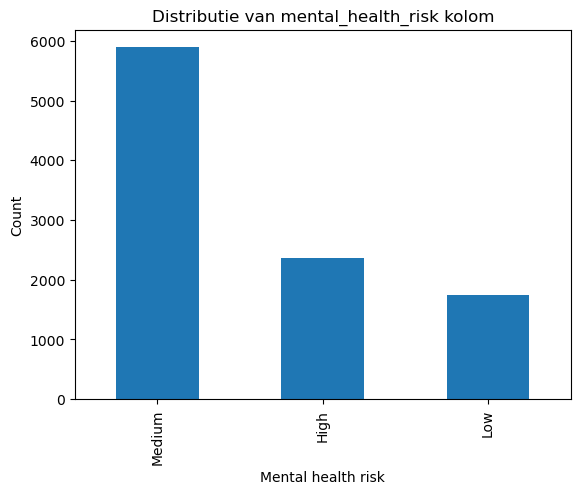

In [35]:
data["mental_health_risk"].value_counts().plot(kind="bar")
plt.title("Distributie van mental_health_risk kolom")
plt.xlabel("Mental health risk")
plt.ylabel("Count")
plt.show()

Het lijkt me ook handig om te kijken naar de spreiding van de numerieke kolommen. Hiervoor maak ik boxplots:

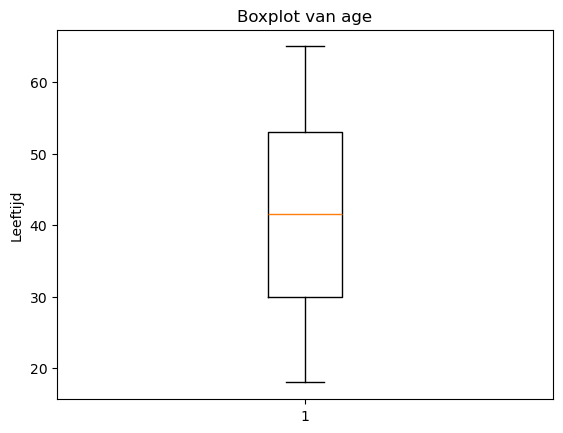

In [38]:
plt.boxplot(data["age"])
plt.title("Boxplot van age")
plt.ylabel("Leeftijd")
plt.show()

De boxplot ziet er prima uit met een mooie spreiding, en geen uitschieters.

## Data Preparation

## Modeling

## Evaluation